# **Preprocesado posterior - Modelado de algoritmos - Resumen y Conclusiones**

**Cargamos 'data_file.csv', que fue el csv resultante del notebook 'NLP_Descarga_y_EDA.ipynb'. Se hace la división de Train y Test, y el etiquetado de las reviews**

In [ ]:
import pandas as pd

def read_csv_data(data_file='./data_file.csv'):
    """data_file.csv fue el dataset obtenido del preprocesado primario del notebook 'NLP_Descargas_y_EDA.ipynb."""

    # Carga del csv resultante del notebook NLP_Descarga_y_EDA.ipynb
    df = pd.read_csv(data_file)

    # Creación de diccionarios de reviews
    data = {'train': {'pos': [], 'neg': []}, 'test': {'pos': [], 'neg': []}}
    labels = {'train': {'pos': [], 'neg': []}, 'test': {'pos': [], 'neg': []}}

    # Iteración en las columnas del DataFrame y se asignan las etiquetas a las reviews
    for index, row in df.iterrows():
        review_text = row['reviewText']
        sentiment_label = row['sentiment_label']

        data_type = 'train' if index % 5 != 0 else 'test'  # Se asigna el 20% de las reviews a Test
        sentiment = 'pos' if sentiment_label == 0 else 'neg'  # Se asigna el 0 como etiqueta a reviews positivas y 1 a reviews negativas

        data[data_type][sentiment].append(review_text)
        labels[data_type][sentiment].append(sentiment_label)

    # Se asegura que los tamaños de datos sean parejas
    for data_type in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                "{}/{} el tamaño de datos no son iguales a las etiquetas".format(data_type, sentiment)

    return data, labels

data, labels = read_csv_data()
print("Reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
    len(data['train']['pos']), len(data['train']['neg']),
    len(data['test']['pos']), len(data['test']['neg'])))

Reviews: train = 8595 pos / 5729 neg, test = 2148 pos / 1433 neg


In [ ]:
data["train"]["pos"][0]

'I got this along with the stuff from OliveNation to do a comparison.  They are NOT equal.  While this extract has no problems imparting a distinct hazelnut flavor, it has about half the potency as the OliveNation stuff does.  I prepared two equal amounts of simple syrup and added teaspoons of both to each until it approached the flavor intensity of Torani Hazelnut syrup.  In 3 cups of syrup, I ended up putting 3 tablespoons (yes big T tablespoons) of this extract to get somewhat close to Torani flavor levels.  That left me with just enough to make about another cup of flavored syrup that was still not as flavorful as Torani.\n\nNeither this or the OliveNation extract contain polyethylene glycol.\n\nIn terms of performance, I am happy with the results.  I use my syrup to flavor coffee and I put about a tablespoon of my flavored syrup in 10oz. of coffee with 6oz. of soymilk.  The concoction is very pleasing (to me) as I get a well rounded flavor palette and not the teeth curling sweetne

In [ ]:
data["train"]["neg"][0]

'very little flavor.  I was disappointed'

**Se crean Word Clouds para visualizar las palabras más comunes en las reviews para eliminar datos innecesarios**

In [ ]:
!pip install wordcloud

**Word Cloud de reviews con rango positivo *(3 a 5 estrellas)*.**

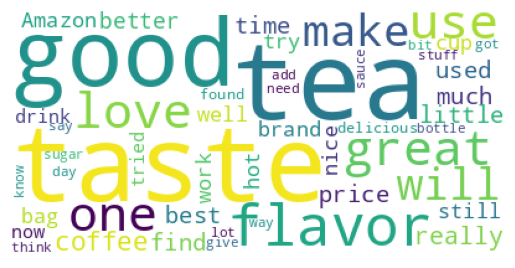

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'pos'

# Combinamos las reviews para el sentimiento deseado
combined_text = " ".join([review for review in data['train'][sentiment]])

# Inicializamos el wordcloud
wc = WordCloud(background_color='white', max_words=50,
        # Actualizamos las stopwords para incluir palabras comunes del tema
        stopwords = STOPWORDS.update(['buy','order','product','bought']))

plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

**Word Cloud de reviews con rango negativo *(1 a 2 estrellas)*.**

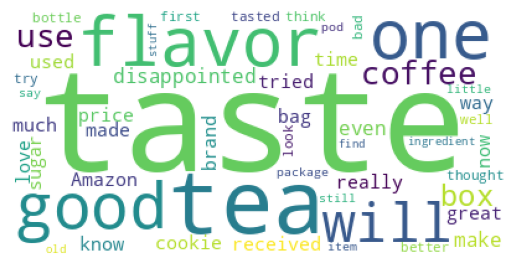

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'neg'

combined_text = " ".join([review for review in data['train'][sentiment]])

wc = WordCloud(background_color='white', max_words=50,
        stopwords = STOPWORDS.update(['buy','bought','review','got','ordered']))

plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

**Preparación de los datos**

In [ ]:
from sklearn.utils import shuffle

def prepare_data_file(data):

    # Combinamos los datos de las diferentes etiquetas
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']

    # Mezclamos los datos con sus etiquetas
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)

    # Devolvemos unificado training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_data_file(data)
print("Reviews combinados: train = {}, test = {}".format(len(data_train), len(data_test)))

Reviews combinados: train = 14324, test = 3581


In [ ]:
# BeautifulSoup para remover tags HTML
from bs4 import BeautifulSoup

# RegEx para remover caracteres que no son letras
import re

import nltk
nltk.download("stopwords")   # Descarga de las Stop Words
from nltk.corpus import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Preprocesamiento de los datos**

In [ ]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""

    # Eliminamos las etiquetas HTML
    text = BeautifulSoup(review, "html5lib").get_text()
    # Convertimos a minúscula y quitamos todo lo que no sea texto o números
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    # Dividimos en tokens por espacios
    words = text.split()
    # Eliminamos stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # Aplicamos stemming
    words = [PorterStemmer().stem(w) for w in words]

    return words

In [ ]:
import pickle
import os

cache_dir = os.path.join("cache", "sentiment_analysis")
os.makedirs(cache_dir, exist_ok=True)

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass

    if cache_data is None:
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))

        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])

    return words_train, words_test, labels_train, labels_test


words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

<ipython-input-9-0616f56f6996>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(review, "html5lib").get_text()


Wrote preprocessed data to cache file: preprocessed_data.pkl

--- Raw review ---
I can't see any difference in me taking tea versus not taking. Maybe dosage needs to be specified to see effects

--- Preprocessed words ---
['see', 'differ', 'take', 'tea', 'versu', 'take', 'mayb', 'dosag', 'need', 'specifi', 'see', 'effect']

--- Label ---
1


**Función para obtener las features del Bag-of-Words**

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import joblib

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extracción del Bag-of-Words de las reviews ya preprocesadas a palabras."""

    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass

    if cache_data is None:
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)
        features_train = vectorizer.fit_transform(words_train).toarray()

        features_test = vectorizer.transform(words_test).toarray()

        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])

    return features_train, features_test, vocabulary

features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

print("\n--- Preprocessed words ---")
print(words_train[7])
print("\n--- Bag-of-Words features ---")
print(features_train[7])
print("\n--- Label ---")
print(labels_train[7])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['final', 'brain', 'around', 'anyon', 'endless', 'antibiot', 'oasi', 'season']

--- Preprocessed words ---
['product', 'arriv', 'time', 'howev', 'fail', 'put', 'name', 'packag', 'mom', 'receiv', 'idea', 'came']

--- Bag-of-Words features ---
[0 0 0 ... 0 0 0]

--- Label ---
0


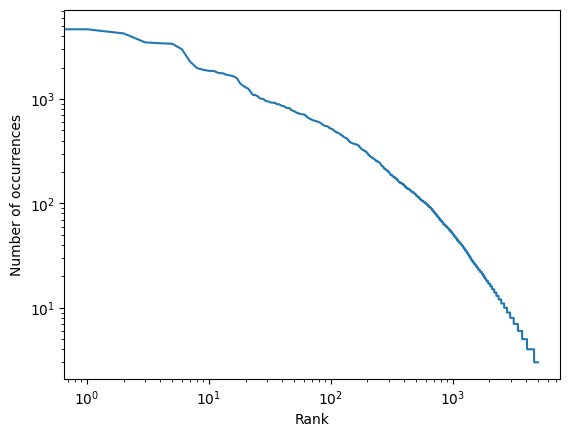

In [ ]:
#Observamos la ley de Zipf
word_freq = features_train.sum(axis=0)

sorted_word_freq = np.sort(word_freq)[::-1]

plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [ ]:
import sklearn.preprocessing as pr

features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

### **Modelo 1: Regresión Logística**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

def classify_logistic_regression(X_train, X_test, y_train, y_test):

    logistic_reg = LogisticRegression(random_state=42)

    logistic_reg.fit(X_train, y_train)

    print("Accuracy score: Train = {:.4f}, Test = {:.4f}".format(logistic_reg.score(X_train, y_train), logistic_reg.score(X_test, y_test)))

    # Predicciones en Test
    y_pred = logistic_reg.predict(X_test)

    # Imprimir la matriz de confusión y el reporte de clasificación
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return logistic_reg

logistic_reg = classify_logistic_regression(features_train, features_test, labels_train, labels_test)

Accuracy score: Train = 0.8355, Test = 0.7978

Confusion Matrix:
[[1864  284]
 [ 440  993]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2148
           1       0.78      0.69      0.73      1433

    accuracy                           0.80      3581
   macro avg       0.79      0.78      0.79      3581
weighted avg       0.80      0.80      0.80      3581



### **Modelo 2: XGBoost**

In [ ]:
import xgboost as xgb

def classify_xgboost(X_train, X_test, y_train, y_test):
    # Hiperparámetros
    params = {
        'n_estimators': 150,
        'learning_rate': 0.1,
        'max_depth': 7,
        'random_state': 42
    }

    xgb_clf = xgb.XGBClassifier(**params)

    xgb_clf.fit(X_train, y_train)

    print("Accuracy score: Train = {:.4f}, Test = {:.4f}".format(xgb_clf.score(X_train, y_train), xgb_clf.score(X_test, y_test)))

    # Predecir en Test
    y_pred = xgb_clf.predict(X_test)

    # Imprimir la matriz de confusión y el reporte de clasificación
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return xgb_clf

xgb_clf = classify_xgboost(features_train, features_test, labels_train, labels_test)

Accuracy score: Train = 0.8696, Test = 0.8054

Confusion Matrix:
[[1947  201]
 [ 496  937]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      2148
           1       0.82      0.65      0.73      1433

    accuracy                           0.81      3581
   macro avg       0.81      0.78      0.79      3581
weighted avg       0.81      0.81      0.80      3581



### **Modelo 3: RNN con GRU**

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import pad_sequences

# Normalización de los datos
scaler = StandardScaler()
features_train_normalized = scaler.fit_transform(features_train)
features_test_normalized = scaler.transform(features_test)

# Preparación de los datos
X_train = np.array(features_train_normalized)
X_test = np.array(features_test_normalized)
y_train = np.array(labels_train)
y_test = np.array(labels_test)

# Calcular la longitud media de los vectores en el conjunto de Train
mean_length = int(np.mean([len(x) for x in X_train]))

# Aplicando un padding a los vectores de Train y Test
X_train = pad_sequences(X_train, maxlen=mean_length)
X_test = pad_sequences(X_test, maxlen=mean_length)

# Redimensionar los datos de la entrada del GRU (3D arrays [samples, time_steps, features])
time_steps = 1  # Ajustar este valor según los datos
X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])

# Definiendo el modelo RNN
model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilando el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenando el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluando el modelo
train_accuracy = model.evaluate(X_train, y_train)[1]
test_accuracy = model.evaluate(X_test, y_test)[1]

# Predicciones en Test
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

print("Accuracy score: Train = {:.4f}, Test = {:.4f}".format(train_accuracy, test_accuracy))

# Imprimir la matriz de confusión y el reporte de clasificación
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

Epoch 1/10
448/448 [==============================] - 14s 9ms/step - loss: 0.9244 - accuracy: 0.7236 - val_loss: 0.5150 - val_accuracy: 0.7975
Epoch 2/10
448/448 [==============================] - 4s 9ms/step - loss: 0.3617 - accuracy: 0.8918 - val_loss: 0.4930 - val_accuracy: 0.8179
Epoch 3/10
448/448 [==============================] - 3s 7ms/step - loss: 0.2272 - accuracy: 0.9486 - val_loss: 0.5210 - val_accuracy: 0.8244
Epoch 4/10
448/448 [==============================] - 3s 8ms/step - loss: 0.1619 - accuracy: 0.9673 - val_loss: 0.5587 - val_accuracy: 0.8283
Epoch 5/10
448/448 [==============================] - 3s 7ms/step - loss: 0.1305 - accuracy: 0.9755 - val_loss: 0.6615 - val_accuracy: 0.8308
Epoch 6/10
448/448 [==============================] - 4s 8ms/step - loss: 0.1110 - accuracy: 0.9781 - val_loss: 0.6264 - val_accuracy: 0.8324
Epoch 7/10
448/448 [==============================] - 3s 7ms/step - loss: 0.1011 - accuracy: 0.9818 - val_loss: 0.6729 - val_accuracy: 0.8291
Epoch

# **Resumen y Métricas**

### Durante la selección de datos para la exploración, se escogió una muestra de 100,000 reviews para no agotar los recursos del entorno gratuito de Google Colab.

### Como un preprocesamiento primario, se balancea las muestras por cada Overall (1, 2, 3, 4, 5), donde cada rango tiene 3,581 muestras. Para calcular la distribución de sentimientos, se estimó que de 1 al 2 es un sentimiento negativo, y del 3 al 5 es un sentimiento positivo.

### Los parámetros de la función 'extract_BoW_features' para hacer el 'Bag-of-Words' con la librería 'CountVectorizer' se detallan en la siguiente parte:

* max_features: Limita el tamaño del vocabulario a las 5,000 palabras más
frecuentes del corpus de Train, reduciendo la dimensionalidad y mejorando la eficiencia en conjuntos de datos grandes.

* preprocessor y tokenizer: No aplican preprocesamientos adicionales al texto antes de la vectorización, pero se pueden personalizar para convertir el texto a minúsculas, eliminar caracteres especiales, entre otros.

* cache_dir y cache_file: Permiten almacenar en caché los resultados del vectorizador para evitar recálculos innecesarios en futuras ejecuciones.

* features_train y features_test: Son los vectores de conteo resultantes de la vectorización, que representan la frecuencia de las palabras en los documentos de Train y Test.

### Al hacer la gráfica de distribución, hay aproximadamente 11,000 reviews con sentimientos positivos; y aproximadamente 7,500 reviews con sentimientos negativos.

### Las primeras 10 palabras en obtenidas en el Word Cloud son: '*taste*', '*tea*', '*good*', '*like*', '*flavor*', '*product*', '*buy*', '*great*', '*try*', '*love*'.

### Al buscar las palabras más cercanas a las 5 primeras palabras del Word Cloud tenemos:

a. Taste:

 [('peppermint', 0.8918583989143372),
 ('lipton', 0.8901620507240295),
 ('jasmine', 0.8891645073890686),
 ('leaf', 0.8847439289093018),
 ('iced', 0.8769845962524414),
 ('refreshing', 0.8713724613189697),
 ('stash', 0.8698018193244934),
 ('twining', 0.8691573143005371),
 ('currant', 0.8667051196098328),
 ('bengal', 0.8640469908714294)]


b. Tea:


[('peppermint', 0.8918583989143372),
 ('lipton', 0.8901620507240295),
 ('jasmine', 0.8891645073890686),
 ('leaf', 0.8847439289093018),
 ('iced', 0.8769845962524414),
 ('refreshing', 0.8713724613189697),
 ('stash', 0.8698018193244934),
 ('twining', 0.8691573143005371),
 ('currant', 0.8667051196098328),
 ('bengal', 0.8640469908714294)]


 c. Good:


 [('terrific', 0.8980239033699036),
 ('decent', 0.889724850654602),
 ('great', 0.8813443183898926),
 ('ok', 0.8791396021842957),
 ('fantastic', 0.8756237626075745),
 ('wonderful', 0.8647668361663818),
 ('acceptable', 0.854860782623291),
 ('affordable', 0.8537380695343018),
 ('consistently', 0.8528507947921753),
 ('lover', 0.852752149105072)]


 d. Like:


 [('kind', 0.9126080274581909),
 ('kinda', 0.8887064456939697),
 ('absolutely', 0.885421097278595),
 ('overly', 0.8806250095367432),
 ('taste', 0.8758636713027954),
 ('remind', 0.8722702264785767),
 ('barely', 0.8693439960479736),
 ('fishy', 0.8624951243400574),
 ('strange', 0.8573544025421143),
 ('unpleasant', 0.8552511930465698)]


 e. Flavor:


 [('distinct', 0.9547448754310608),
 ('subtle', 0.9314885139465332),
 ('earthy', 0.9163172245025635),
 ('combination', 0.9095458984375),
 ('hint', 0.9081805944442749),
 ('prefer', 0.9068789482116699),
 ('clove', 0.905543863773346),
 ('fragrance', 0.9049835205078125),
 ('bland', 0.898010790348053),
 ('flavour', 0.8958067893981934)]


 ### Utilizando el dataset 'data_file.csv', obtenido del preprocesamiento primario. Se realiza la separación de Train y Test, se carga y se realiza un nuevo procesamiento para separar las reviews positivas y negativas por listas. Luego, con las reviews clasificadas, se aplicó nuevamente Word Clouds para visualizar las palabras más repetidas y poder eliminarlas con la función Stop Word.

 ### Se unen las reviews positivas y negativas para aplicarlas a una nuevo proceso de limpieza utilizando Beautifulsoup para eliminar las tags HTML que pudieran tener las reviews. No es común que en las reviews se tenga, pero puede haber excepciones. Además se hizo la normalización haciendo que todas las palabras estén en minúscula, y eliminación de caracteres que no son letras.

 ### Con los datos preparados, se utilizaron los siguientes modelos de algoritmos de clasificación:



1.   Regresión Logística: Obteniendo un Accuracy score en Test de 0.7978.
2.   XGBoost: Obteniendo un Accuracy score en Test de 0.8054.
3.   RNN con GRU: Obteniendo un Accuracy score en Test de 0.8335.




# **Conclusiones finales**

Por los resultados obtenidos en las diferentes visualizaciones, la mayoría de las reviews fueron del rango positivo *(3 a 5 estrellas)*. Por las palabras vistas en los Word Clouds, parece que había más comentarios relacionados con bebidas *(tea, coffee, bottle, cup, drink)*.

En cuanto a los resultados de los modelos aplicados para clasificación de las reviews, el que mejor rendimiento dio fue la 'RNN con GRU' con un Accuracy en Test de 0.8341. Posiblemente haya overfiting en este modelo porque el Accuracy en Train es superior a 0.95, pero los resultados en Test son muy buenos, incluso mejorables. Con mayor cantidad de reviews, un mejor entorno de ejecución y agregando mayor cantidad de Epoch, se pudiera conseguir un Accuracy en Test superior al obtenido.

**Aquí la matriz de confusión y Classification Report del modelo RNN con GRU:**

Confusion Matrix:

                    [[1870  278]
                    [ 311 1122]]

Classification Report:

                                     precision    recall  f1-score   support

                  0 (c. positivos)      0.86      0.87      0.86      2148
                  1 (c. negativos)      0.80      0.78      0.79      1433

**Posiblemente si se tuviera mayor cantidad de reviews, fuera necesario un preprocesado más exaustivo, ya que fue necesario hacer varias visualizaciones para detectar palabras outliers que eliminar.**